In [1]:
VERSION = 8

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

train = pd.read_csv("data/train.csv") 
print("Train shape:", train.shape )
TRAIN_LN = len(train)
display( train.head(1) )

test = pd.read_csv("data/test.csv") 
test['price'] = 0 # Doing this for common pre-processing steps.
print("Test shape:", test.shape )
display( test.head(1) )

train = pd.concat([train,test],axis=0,ignore_index=True)
print("Combined shape:", train.shape )

Train shape: (188533, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200


Test shape: (125690, 13)


,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes,0


Combined shape: (314223, 13)


In [3]:
CATS = [c for c in train.columns if not c in ["id","price"] ]
NUMS = ['milage']
CATS = [c for c in CATS if not c in NUMS]
print("Categorical features:", CATS )
print("Numerical features:", NUMS)

Categorical features: ['brand', 'model', 'model_year', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
Numerical features: ['milage']


In [4]:
print("STANDARDIZING NUMERICAL FEATURES")
for c in NUMS:
    m = train[c].mean()
    s = train[c].std()
    train[c] = (train[c]-m)/s
    train[c] = train[c].fillna(m)
    print(f"{c}, new_mean={train[c].mean():.2f}, new_std={train[c].std():.2f}")

STANDARDIZING NUMERICAL FEATURES
milage, new_mean=-0.00, new_std=1.00


In [5]:
cat_feature_sizes = []
cat_embedding_sizes = []
rare_cat_lists = []
MIN_CATEGORY_COUNT = 40

print("Label Encoding Categorical Features:")
for cat_feature in CATS:
    train[cat_feature], _ = train[cat_feature].factorize()
    train[cat_feature] -= train[cat_feature].min() # We are doing this to ensure that the encoded values start from 0, ensuring a consistent range for all categorical features.
    value_counts = train[cat_feature].value_counts().to_dict()
    
    # Identify rare categories
    rare_cat_lists.append([
        value
        for value, count in value_counts.items()
        if count < MIN_CATEGORY_COUNT
    ])
    unique_count = train[cat_feature].nunique()
    min_freq = train[cat_feature].min()
    max_freq = train[cat_feature].max()
    rare_count = len(rare_cat_lists[-1])
    print(f'{cat_feature}: unique={unique_count}, min_freq={min_freq}, max_freq={max_freq}, rare_count={rare_count}')
    
    # Adjust category encoding
    cat_feature_sizes.append(max_freq + 2)  # +2 for rare category (0) and zero-indexing (1 to max_freq+1). This ensures we have enough space for all categories, including the rare ones grouped together.
    cat_embedding_sizes.append(int(np.ceil(np.sqrt(max_freq + 2)))) # TODO: Find a reference for this formula. Got this snippet from https://www.kaggle.com/code/cdeotte/nn-starter-lb-72300-cv-72800
    train[cat_feature] += 1
    train.loc[train[cat_feature].isin(rare_cat_lists[-1]), cat_feature] = 0 # rare_cat_lists[-1] gives the list of rare categories for the current feature

Label Encoding Categorical Features:
brand: unique=57, min_freq=0, max_freq=56, rare_count=8
model: unique=1898, min_freq=0, max_freq=1897, rare_count=551
model_year: unique=36, min_freq=0, max_freq=35, rare_count=4
fuel_type: unique=8, min_freq=0, max_freq=7, rare_count=1
engine: unique=1118, min_freq=0, max_freq=1117, rare_count=308
transmission: unique=52, min_freq=0, max_freq=51, rare_count=8
ext_col: unique=319, min_freq=0, max_freq=318, rare_count=99
int_col: unique=156, min_freq=0, max_freq=155, rare_count=48
accident: unique=3, min_freq=0, max_freq=2, rare_count=0
clean_title: unique=2, min_freq=0, max_freq=1, rare_count=0


In [6]:
test = train.iloc[TRAIN_LN:]
train = train.iloc[:TRAIN_LN]
train.shape, test.shape

((188533, 13), (125690, 13))

In [7]:
for feature in CATS:
    train_categories = train[feature].unique()
    test_categories = test[feature].unique()
    unseen_categories = np.setdiff1d(test_categories, train_categories)
    print(f"{feature}: Test has label encodes = {unseen_categories} which are not in train.")
    if len(unseen_categories) > 0:
        unseen_rows_count = len(test.loc[test[feature].isin(unseen_categories)])
        print(f" => {unseen_rows_count} rows")
    
    test.loc[test[feature].isin(unseen_categories), feature] = 0

brand: Test has label encodes = [] which are not in train.
model: Test has label encodes = [1898] which are not in train.
 => 1 rows
model_year: Test has label encodes = [36] which are not in train.
 => 1 rows
fuel_type: Test has label encodes = [] which are not in train.
engine: Test has label encodes = [1118] which are not in train.
 => 4 rows
transmission: Test has label encodes = [] which are not in train.
ext_col: Test has label encodes = [] which are not in train.
int_col: Test has label encodes = [] which are not in train.
accident: Test has label encodes = [] which are not in train.
clean_title: Test has label encodes = [] which are not in train.


In [8]:
# Apply log transformation to price
train['log_price'] = np.log1p(train['price'])
test['log_price'] = np.log1p(test['price'])

# Standardize the log-transformed price
price_mean = train['log_price'].mean()
price_std = train['log_price'].std()

train['norm_price'] = (train['log_price'] - price_mean) / price_std
test['norm_price'] = (test['log_price'] - price_mean) / price_std

print("Normalized price statistics:")
print(f"Train - Mean: {train['norm_price'].mean():.4f}, Std: {train['norm_price'].std():.4f}")
print(f"Test  - Mean: {test['norm_price'].mean():.4f}, Std: {test['norm_price'].std():.4f}")

# Update the target variable
target = 'norm_price'


Normalized price statistics:
Train - Mean: -0.0000, Std: 1.0000
Test  - Mean: -12.1916, Std: 0.0000


In [9]:
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding
from tensorflow.keras.layers import Concatenate, Multiply
import tensorflow.keras.backend as K

print('TF Version',tf.__version__)

TF Version 2.16.1


Learning rate schedule: 0.001 to 0.001 to 1e-05


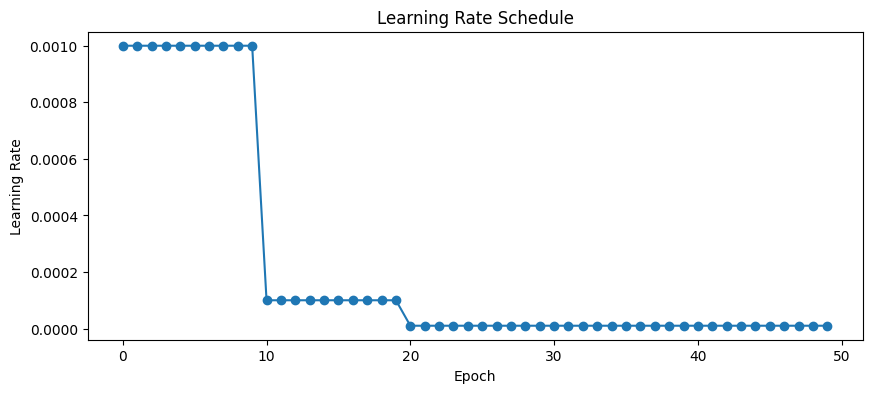

In [15]:
EPOCHS = 50
LRS = [0.001]*10 + [0.0001]*10 + [0.00001]*30  # Extended schedule for 50 epochs

def lrfn(epoch):
    return LRS[epoch]

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
        format(lr_y[0], max(lr_y), lr_y[-1]))
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [16]:
def build_model():
    DROPOUT_RATE = 0.3

    # CATEGORICAL FEATURES
    x_input_cats = Input(shape=(len(CATS),))
    embs = []
    for j in range(len(CATS)):
        e = tf.keras.layers.Embedding(cat_feature_sizes[j],cat_embedding_sizes[j])
        x = e(x_input_cats[:,j])
        x = tf.keras.layers.Flatten()(x)
        embs.append(x)
        
    # NUMERICAL FEATURES
    x_input_nums = Input(shape=(len(NUMS),))
    
    # COMBINE
    x = tf.keras.layers.Concatenate(axis=-1)(embs+[x_input_nums]) 
    x = Dense(512, activation='relu')(x)
    x = Dropout(DROPOUT_RATE)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(DROPOUT_RATE)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[x_input_cats,x_input_nums], outputs=x)
    
    return model

In [22]:
import os
import numpy as np
import tensorflow as tf

NUM_FOLDS = 5
RANDOM_STATE = 42
MODEL_CHECKPOINT_DIR = f"checkpoints/"
MODEL_CHECKPOINT_FILE = f"NN_{VERSION}.weights.h5"
TENSORBOARD_LOG_DIR = f"tensorboard_logs/version_{VERSION}"

kf = KFold(n_splits=NUM_FOLDS, random_state=RANDOM_STATE, shuffle=True)

out_of_fold_predictions = np.zeros(len(train))
test_predictions = np.zeros(len(test))

# Create directory for model checkpoints
if not os.path.exists(MODEL_CHECKPOINT_DIR):
    os.makedirs(MODEL_CHECKPOINT_DIR)

# Create directory for TensorBoard logs
if not os.path.exists(TENSORBOARD_LOG_DIR):
    os.makedirs(TENSORBOARD_LOG_DIR)

# Implement inverse_normalize_price function using TensorFlow operations
def inverse_normalize_price(normalized_price):
    return tf.math.expm1(normalized_price * price_std + price_mean)

# Custom RMSE metric for original price
@tf.function
def original_price_rmse(y_true, y_pred):
    y_true_original = inverse_normalize_price(y_true)
    y_pred_original = inverse_normalize_price(y_pred)
    return tf.sqrt(tf.reduce_mean(tf.square(y_true_original - y_pred_original)))

for fold, (train_index, val_index) in enumerate(kf.split(train), 1):
    print("#" * 25)
    print(f"### Fold {fold} ###")
    print("#" * 25)

    # Prepare data for current fold
    X_train_cats = train.loc[train_index, CATS].values
    X_train_nums = train.loc[train_index, NUMS].values
    y_train = train.loc[train_index, "norm_price"].values
    
    X_val_cats = train.loc[val_index, CATS].values
    X_val_nums = train.loc[val_index, NUMS].values
    y_val = train.loc[val_index, "norm_price"].values
    
    X_test_cats = test[CATS].values
    X_test_nums = test[NUMS].values
    
    # Train model
    K.clear_session()
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                  loss="mean_squared_error", 
                  metrics=[tf.keras.metrics.RootMeanSquaredError(), original_price_rmse])
    
    # Create TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=f"{TENSORBOARD_LOG_DIR}/fold_{fold}",
        histogram_freq=1,
        write_graph=True,
        write_images=True,
        update_freq='epoch',
        profile_batch=0
    )
    
    # Create Early Stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_original_price_rmse',
        patience=5,
        mode='min',
        restore_best_weights=True
    )
    
    # Create ReduceLROnPlateau callback
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_original_price_rmse',
        factor=0.1,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1
    )
    
    model.fit([X_train_cats, X_train_nums], y_train, 
              validation_data=([X_val_cats, X_val_nums], y_val),
              callbacks=[reduce_lr, tensorboard_callback, early_stopping],
              batch_size=64, epochs=EPOCHS, verbose=2)
    
    # Save model weights
    model.save_weights(f'{MODEL_CHECKPOINT_DIR}/{MODEL_CHECKPOINT_FILE}')
    
    # Make predictions on validation set
    val_predictions = model.predict([X_val_cats, X_val_nums], verbose=1, batch_size=512).flatten()
    val_predictions_original = inverse_normalize_price(val_predictions).numpy()
    y_val_original = inverse_normalize_price(y_val).numpy()
    rmse = np.sqrt(np.mean((val_predictions_original - y_val_original)**2))
    print(f' => Original Price RMSE = {rmse}\n')
    
    # Store out-of-fold predictions
    out_of_fold_predictions[val_index] = val_predictions_original
    
    # Make predictions on test set
    fold_test_predictions = model.predict([X_test_cats, X_test_nums], verbose=1, batch_size=512).flatten()
    fold_test_predictions_original = inverse_normalize_price(fold_test_predictions).numpy()
    test_predictions += fold_test_predictions_original

# Average test predictions across all folds
test_predictions /= NUM_FOLDS

#########################
### Fold 1 ###
#########################
Epoch 1/50
2357/2357 - 8s - 3ms/step - loss: 0.3689 - original_price_rmse: 63130.7383 - root_mean_squared_error: 0.6074 - val_loss: 0.3506 - val_original_price_rmse: 60087.5938 - val_root_mean_squared_error: 0.5921 - learning_rate: 0.0010
Epoch 2/50
2357/2357 - 6s - 3ms/step - loss: 0.3484 - original_price_rmse: 63028.6211 - root_mean_squared_error: 0.5902 - val_loss: 0.3487 - val_original_price_rmse: 60642.0078 - val_root_mean_squared_error: 0.5905 - learning_rate: 0.0010
Epoch 3/50

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2357/2357 - 6s - 3ms/step - loss: 0.3412 - original_price_rmse: 63545.6445 - root_mean_squared_error: 0.5842 - val_loss: 0.3475 - val_original_price_rmse: 61550.5977 - val_root_mean_squared_error: 0.5895 - learning_rate: 0.0010
Epoch 4/50
2357/2357 - 6s - 3ms/step - loss: 0.3216 - original_price_rmse: 63400.9336 - root_mean_squared_error: 0.5671 - val_loss: 0.3464

In [23]:
# COMPUTE AND DISPLAY CV RSME SCORE
rsme = np.sqrt(np.mean( (out_of_fold_predictions-train.price.values)**2 ))
print("Overall CV RSME =",rsme)

# SAVE OOF 
oof_df = train[["id"]].copy()
oof_df["pred"] = out_of_fold_predictions
oof_df.to_csv(f"predictions/oof_v{VERSION}.csv",index=False)

Overall CV RSME = 73837.35494111072


In [24]:
sub = pd.read_csv("data/sample_submission.csv")
sub.price = test_predictions
print("Submission shape:",sub.shape)
sub.to_csv(f"predictions/submission_v{VERSION}.csv",index=False)
sub.head()

Submission shape: (125690, 2)


,id,price
0,188533,17075.755469
1,188534,60272.837500
2,188535,48256.589844
3,188536,25167.990625
4,188537,29578.787109
